# ChEMBL Activity Data Filtering Test

This notebook tests the filtering pipeline on a subset of systems before applying to all data.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline

## Inspect Current Data Structure

Let's first check what fields we actually have in the retrieved data.

In [2]:
# Load a sample file to inspect structure
sample_file = 'data/affinity/5sc8/5sc8_chembl_activities.csv'
sample_df = pd.read_csv(sample_file)

print("Available columns in current data:")
print("="*60)
for i, col in enumerate(sample_df.columns, 1):
    dtype = sample_df[col].dtype
    non_null = sample_df[col].notna().sum()
    null_count = sample_df[col].isna().sum()
    print(f"{i:2d}. {col:30s} ({dtype}) - {non_null} non-null, {null_count} null")

print(f"\n{sample_df.shape[0]} total rows")
print("\nSample data:")
print(sample_df.head(3))

Available columns in current data:
 1. molecule_chembl_id             (object) - 60 non-null, 0 null
 2. canonical_smiles               (object) - 60 non-null, 0 null
 3. standard_type                  (object) - 60 non-null, 0 null
 4. standard_value                 (float64) - 46 non-null, 14 null
 5. standard_units                 (object) - 46 non-null, 14 null
 6. pchembl_value                  (float64) - 46 non-null, 14 null
 7. activity_comment               (object) - 14 non-null, 46 null
 8. assay_chembl_id                (object) - 60 non-null, 0 null
 9. confidence_score               (int64) - 60 non-null, 0 null
10. target_chembl_id               (object) - 60 non-null, 0 null
11. document_chembl_id             (object) - 60 non-null, 0 null
12. source_pdb_id                  (object) - 60 non-null, 0 null
13. source_uniprot_id              (object) - 60 non-null, 0 null

60 total rows

Sample data:
  molecule_chembl_id                                  canonical_smiles  \

## Define filtering functions based on notebook analysis

## Missing Annotations for Full Paper Curation

Based on the paper's methodology, the following additional fields from ChEMBL are required:

### 1. **Mutant/Variant Filtering**
**Required fields:**
- `variant_id` (INTEGER) - Links to variant_sequences table for protein mutations
- `assay.description` (TEXT) - Full text description to pattern match 'mutant', 'mutation', 'variant'

**Current CSV:** ❌ Not available
**Impact:** Cannot filter out mutant proteins (may compare wild-type vs mutant data)

---

### 2. **Document-Based Filtering**
**Required fields:**
- `docs.year` (INTEGER) - Publication year
- `docs.doc_date` (DATE) - Full publication date
- `assays.doc_id` (INTEGER) - Document identifier

**Current CSV:** ✅ `document_chembl_id` available, ❌ but no `doc_date`/`year`
**Impact:** Cannot filter unpublished/internal assays; Cannot implement `noDuplicateDocs` properly

---

### 3. **Cross-Assay Analysis**
**Required fields for overlap detection:**
- Multiple assays per target (need aggregation across all systems)
- `activity_id` (INTEGER) - Unique activity identifier
- Full activity table structure (not per-PDB split)

**Current CSV:** ❌ Data is split by PDB structure, not by target
**Impact:** Cannot find overlapping compounds between different assays of same target

---

### 4. **Assay Matching Conditions (maxMatch=True)**
**Required fields from assays table:**
- `assay_type` (VARCHAR) - e.g., 'B' (binding), 'F' (functional)
- `assay_organism` (VARCHAR) - e.g., 'Homo sapiens'
- `assay_category` (VARCHAR) - e.g., 'confirmatory', 'screening'
- `assay_tax_id` (INTEGER) - NCBI taxonomy ID
- `assay_strain` (VARCHAR) - Organism strain
- `assay_tissue` (VARCHAR) - Tissue source
- `assay_cell_type` (VARCHAR) - Cell line used
- `assay_subcellular_fraction` (VARCHAR) - e.g., 'membrane', 'cytosol'
- `bao_format` (VARCHAR) - BioAssay Ontology format
- `variant_id` (INTEGER) - Again, for variant matching

**Current CSV:** ❌ None of these available
**Impact:** Cannot ensure assays are methodologically comparable

---

### 5. **Activity Curation Details**
**Required fields:**
- `standard_relation` (VARCHAR) - '=', '>', '<', '~'
- `data_validity_comment` (VARCHAR) - Quality flags from ChEMBL curators
- `activity_comment` (TEXT) - Free text comments

**Current CSV:** 
- ✅ `activity_comment` available (partially useful)
- ❌ `standard_relation` not available
- ❌ `data_validity_comment` not clearly mapped

**Impact:** Cannot filter out approximate values or flagged data

---

### 6. **Assay Size Calculations**
**Required:**
- Access to full activities table to count distinct compounds per assay
- Ability to filter by compound count BEFORE analysis

**Current CSV:** ❌ Pre-filtered to specific PDB structures
**Impact:** Cannot apply "goldilocks" range (20-100 compounds per assay)

---

## Summary: What You Need to Retrieve

To match the paper's exact curation, you need to query ChEMBL for these additional tables/joins:

```sql
-- Core tables needed
activities (full table, not PDB-filtered)
assays (with all 10+ condition fields)
docs (with publication dates)
target_dictionary (already have via target_chembl_id)
variant_sequences (for mutant filtering)
```

### Recommended Query Structure:

```sql
SELECT 
    -- Current fields (you have these)
    acts.molecule_chembl_id,
    cmpd.canonical_smiles,
    acts.standard_type,
    acts.standard_value,
    acts.standard_units,
    acts.pchembl_value,
    acts.assay_chembl_id,
    acts.target_chembl_id,
    acts.document_chembl_id,
    
    -- MISSING: Activity metadata
    acts.activity_id,
    acts.standard_relation,
    acts.data_validity_comment,
    acts.activity_comment,
    
    -- MISSING: Assay details
    assays.assay_type,
    assays.assay_organism,
    assays.assay_category,
    assays.assay_tax_id,
    assays.assay_strain,
    assays.assay_tissue,
    assays.assay_cell_type,
    assays.assay_subcellular_fraction,
    assays.bao_format,
    assays.description AS assay_description,
    assays.variant_id,
    assays.confidence_score,
    
    -- MISSING: Document info
    docs.year AS doc_year,
    docs.doc_date,
    
    -- MISSING: Variant info
    variants.mutation AS variant_mutation
    
FROM activities acts
JOIN assays ON acts.assay_id = assays.assay_id
JOIN target_dictionary tgt ON assays.tid = tgt.tid
JOIN compound_structures cmpd ON acts.molregno = cmpd.molregno
LEFT JOIN docs ON assays.doc_id = docs.doc_id
LEFT JOIN variant_sequences variants ON assays.variant_id = variants.variant_id
WHERE 
    tgt.target_type = 'SINGLE PROTEIN'
    AND acts.standard_type IN ('IC50', 'Ki')
    AND acts.standard_units = 'nM'
    -- Add your target/PDB filtering here
```

### Alternative: Work with What You Have

If retrieving all this data is difficult, you can:
1. **Accept "minimal curation"** - Use current filters (still quite good!)
2. **Document limitations** - Note that cross-assay reproducibility not assessed
3. **Focus on within-system quality** - Your current approach is valid for ML training

The paper's "max curation" is specifically for **studying assay reproducibility**. For **building training datasets**, your current approach captures the most critical quality filters! 🎯

In [3]:
def filter_chembl_data(df, standard_types=['IC50', 'Ki', 'Kd'], verbose=True):
    """
    Apply filtering steps to ChEMBL activity data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with ChEMBL activities
    standard_types : list or str
        Standard types to keep (e.g., ['IC50', 'Ki', 'Kd'] or 'IC50')
    verbose : bool
        Print filtering statistics
    
    Returns:
    --------
    pd.DataFrame, dict
        Filtered dataframe and filtering statistics
    """
    stats = {'initial': len(df)}
    
    # Convert string to list if needed
    if isinstance(standard_types, str):
        standard_types = [standard_types]
    
    # Step 1: Standard type (IC50, Ki, Kd)
    df = df[df['standard_type'].isin(standard_types)].copy()
    stats['after_standard_type'] = len(df)
    if verbose:
        print(f"After standard_type filter ({', '.join(standard_types)}): {len(df)} rows")
        if len(df) > 0:
            print(f"  Type distribution: {df['standard_type'].value_counts().to_dict()}")
    
    # Step 2: Standard units (nM)
    df = df[df['standard_units'] == 'nM'].copy()
    stats['after_standard_units'] = len(df)
    if verbose:
        print(f"After standard_units filter (nM): {len(df)} rows")
    
    # Step 3: pChEMBL value must exist
    df = df[df['pchembl_value'].notna()].copy()
    stats['after_pchembl_exists'] = len(df)
    if verbose:
        print(f"After pchembl_value exists: {len(df)} rows")
    
    # Step 4: Data validity comment should be null (no comments means valid)
    # Note: activity_comment in the CSV might correspond to data_validity_comment
    # We'll keep rows where activity_comment is NaN or empty
    if 'activity_comment' in df.columns:
        df = df[df['activity_comment'].isna() | (df['activity_comment'] == '')].copy()
        stats['after_data_validity'] = len(df)
        if verbose:
            print(f"After data_validity filter: {len(df)} rows")
    
    # Step 5: Confidence score = 9 (high confidence)
    df = df[df['confidence_score'] == 9].copy()
    stats['after_confidence'] = len(df)
    if verbose:
        print(f"After confidence_score filter (9): {len(df)} rows")
    
    # Step 6: Remove duplicates (same molecule, assay, activity)
    before_dedup = len(df)
    df = df.drop_duplicates(subset=['molecule_chembl_id', 'assay_chembl_id', 'pchembl_value']).copy()
    stats['after_deduplication'] = len(df)
    if verbose:
        print(f"After deduplication: {len(df)} rows (removed {before_dedup - len(df)} duplicates)")
    
    return df, stats


def analyze_system(system_id, base_path='data/affinity', standard_types=['IC50', 'Ki', 'Kd']):
    """
    Analyze a single system and return filtering statistics.
    """
    csv_path = Path(base_path) / system_id / f"{system_id}_chembl_activities.csv"
    
    if not csv_path.exists():
        return None, None
    
    # Read the data
    df = pd.read_csv(csv_path)
    
    print(f"\n{'='*60}")
    print(f"System: {system_id}")
    print(f"{'='*60}")
    print(f"Initial rows: {len(df)}")
    print(f"Unique molecules: {df['molecule_chembl_id'].nunique()}")
    print(f"Unique assays: {df['assay_chembl_id'].nunique()}")
    print(f"Unique targets: {df['target_chembl_id'].nunique()}")
    print(f"Standard types: {df['standard_type'].value_counts().to_dict()}")
    print()
    
    # Apply filtering
    filtered_df, stats = filter_chembl_data(df, standard_types=standard_types, verbose=True)
    
    print(f"\nFinal statistics:")
    print(f"  Molecules: {filtered_df['molecule_chembl_id'].nunique()}")
    print(f"  Assays: {filtered_df['assay_chembl_id'].nunique()}")
    print(f"  Targets: {filtered_df['target_chembl_id'].nunique()}")
    print(f"  pChEMBL range: [{filtered_df['pchembl_value'].min():.2f}, {filtered_df['pchembl_value'].max():.2f}]")
    
    return filtered_df, stats

## Test on a few systems

In [4]:
# Test on first 5 systems
test_systems = ['5sc8', '5sc9', '5sca', '5scb', '5scc']

results = {}
all_stats = {}

for system_id in test_systems:
    filtered_df, stats = analyze_system(system_id, standard_types=['IC50', 'Ki', 'Kd'])
    if filtered_df is not None:
        results[system_id] = filtered_df
        all_stats[system_id] = stats


System: 5sc8
Initial rows: 60
Unique molecules: 51
Unique assays: 9
Unique targets: 1
Standard types: {'IC50': 58, 'Ki': 2}

After standard_type filter (IC50, Ki, Kd): 60 rows
  Type distribution: {'IC50': 58, 'Ki': 2}
After standard_units filter (nM): 46 rows
After pchembl_value exists: 46 rows
After data_validity filter: 46 rows
After confidence_score filter (9): 46 rows
After deduplication: 40 rows (removed 6 duplicates)

Final statistics:
  Molecules: 37
  Assays: 9
  Targets: 1
  pChEMBL range: [4.41, 7.55]

System: 5sc9
Initial rows: 60
Unique molecules: 51
Unique assays: 9
Unique targets: 1
Standard types: {'IC50': 58, 'Ki': 2}

After standard_type filter (IC50, Ki, Kd): 60 rows
  Type distribution: {'IC50': 58, 'Ki': 2}
After standard_units filter (nM): 46 rows
After pchembl_value exists: 46 rows
After data_validity filter: 46 rows
After confidence_score filter (9): 46 rows
After deduplication: 40 rows (removed 6 duplicates)

Final statistics:
  Molecules: 37
  Assays: 9
  Tar

## Summary of filtering impact

In [5]:
# Create summary table
summary_rows = []
for system_id, stats in all_stats.items():
    row = {'system': system_id}
    row.update(stats)
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\n" + "="*80)
print("FILTERING SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))


FILTERING SUMMARY
system  initial  after_standard_type  after_standard_units  after_pchembl_exists  after_data_validity  after_confidence  after_deduplication
  5sc8       60                   60                    46                    46                   46                46                   40
  5sc9       60                   60                    46                    46                   46                46                   40
  5sca       60                   60                    46                    46                   46                46                   40
  5scb       60                   60                    46                    46                   46                46                   40
  5scc       60                   60                    46                    46                   46                46                   40


## Visualize filtering impact

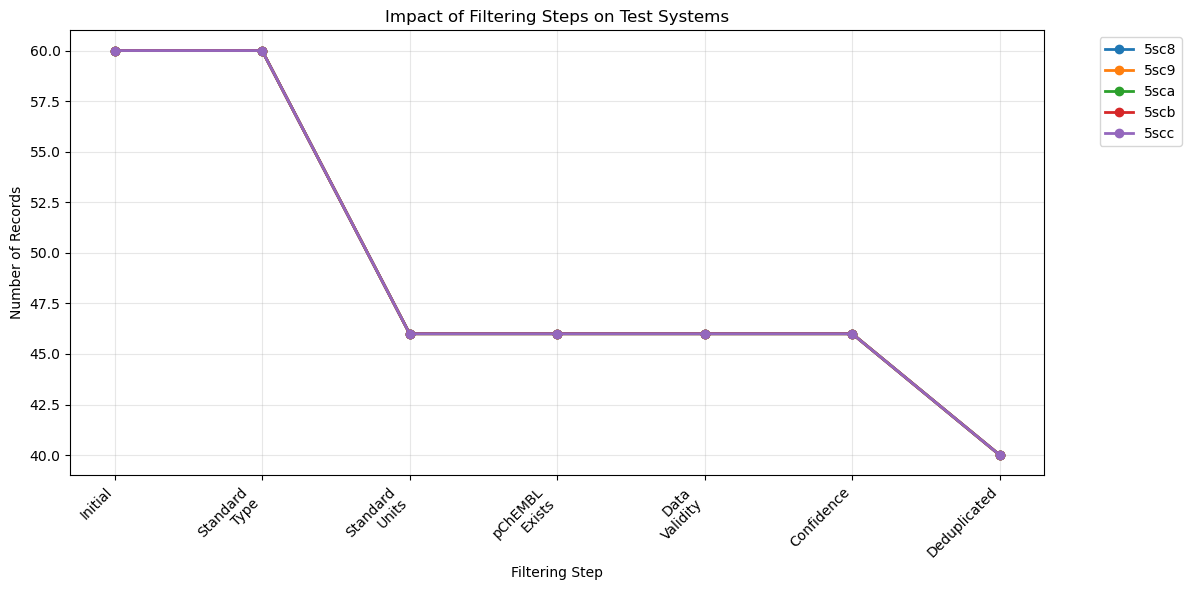

In [6]:
if len(summary_df) > 0:
    # Plot the progression of filtering
    fig, ax = plt.subplots(figsize=(12, 6))
    
    filter_steps = ['initial', 'after_standard_type', 'after_standard_units', 
                    'after_pchembl_exists', 'after_data_validity', 
                    'after_confidence', 'after_deduplication']
    
    step_labels = ['Initial', 'Standard\nType', 'Standard\nUnits', 
                   'pChEMBL\nExists', 'Data\nValidity', 
                   'Confidence', 'Deduplicated']
    
    for system_id in summary_df['system']:
        values = [summary_df[summary_df['system'] == system_id][step].values[0] 
                  for step in filter_steps]
        ax.plot(range(len(filter_steps)), values, marker='o', label=system_id, linewidth=2)
    
    ax.set_xticks(range(len(filter_steps)))
    ax.set_xticklabels(step_labels, rotation=45, ha='right')
    ax.set_ylabel('Number of Records')
    ax.set_xlabel('Filtering Step')
    ax.set_title('Impact of Filtering Steps on Test Systems')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Check retention rate

In [7]:
if len(summary_df) > 0:
    summary_df['retention_rate'] = (summary_df['after_deduplication'] / summary_df['initial'] * 100).round(2)
    print("\nRetention rates after all filtering:")
    print(summary_df[['system', 'initial', 'after_deduplication', 'retention_rate']].to_string(index=False))
    print(f"\nAverage retention rate: {summary_df['retention_rate'].mean():.2f}%")


Retention rates after all filtering:
system  initial  after_deduplication  retention_rate
  5sc8       60                   40           66.67
  5sc9       60                   40           66.67
  5sca       60                   40           66.67
  5scb       60                   40           66.67
  5scc       60                   40           66.67

Average retention rate: 66.67%


## Save filtered data for inspection

In [8]:
# Save one example for inspection
if results:
    example_system = test_systems[0]
    if example_system in results:
        output_path = f'data/affinity_test/{example_system}_filtered.csv'
        Path('data/affinity_test').mkdir(parents=True, exist_ok=True)
        results[example_system].to_csv(output_path, index=False)
        print(f"\nSaved filtered data for {example_system} to {output_path}")


Saved filtered data for 5sc8 to data/affinity_test/5sc8_filtered.csv


## Comparison: Paper vs Current Implementation

### Fields Comparison Table

In [ ]:
import pandas as pd

# Create comparison table
comparison_data = {
    'Filtering Step': [
        'Standard Type (IC50/Ki)',
        'Standard Units (nM)',
        'pChEMBL Value Present',
        'Data Validity Comment',
        'Standard Relation (=)',
        'Confidence Score (9)',
        'Target Type (SINGLE PROTEIN)',
        'Document Has Date',
        'Mutant/Variant Removal',
        'No Duplicate Documents',
        'Assay Size (20-100 compounds)',
        'Activity Value Curation (Δ≠3.0)',
        'Assay Matching (10+ conditions)',
        'Cross-Assay Overlap Analysis'
    ],
    'Paper Implementation': [
        '✓ Required',
        '✓ Required',
        '✓ Required',
        '✓ Required',
        '✓ Required',
        '✓ Optional (onlyHighConfidence)',
        '✓ Required',
        '✓ Optional (onlyDocs)',
        '✓ Optional (removeMutants)',
        '✓ Optional (noDuplicateDocs)',
        '✓ Optional (minAssaySize/maxAssaySize)',
        '✓ Optional (includeActivityCuration)',
        '✓ Optional (maxMatch)',
        '✓ Core Feature'
    ],
    'Current CSV Has Data': [
        '✓ Yes (standard_type)',
        '✓ Yes (standard_units)',
        '✓ Yes (pchembl_value)',
        '~ Partial (activity_comment)',
        '✗ No (missing field)',
        '✓ Yes (confidence_score)',
        '✗ Assumed (not in CSV)',
        '✗ No (missing doc_date)',
        '✗ No (no variant_id/description)',
        '✗ No (missing doc metadata)',
        '✗ No (data pre-filtered by PDB)',
        '✗ N/A (single system files)',
        '✗ No (missing assay details)',
        '✗ N/A (data split by PDB)'
    ],
    'Your Implementation': [
        '✓ Implemented',
        '✓ Implemented',
        '✓ Implemented',
        '✓ Implemented (activity_comment)',
        '✗ Cannot implement',
        '✓ Implemented',
        '✗ Not verified',
        '✗ Cannot implement',
        '✗ Cannot implement',
        '✗ Cannot implement',
        '✗ Not implemented (could add)',
        '✗ N/A (single system)',
        '✗ Cannot implement',
        '✗ N/A (single system)'
    ],
    'Required Fields': [
        'standard_type',
        'standard_units',
        'pchembl_value',
        'data_validity_comment',
        'standard_relation',
        'confidence_score',
        'target.target_type',
        'docs.year, docs.doc_date',
        'variant_id, assay.description',
        'assay.doc_id, docs.doc_date',
        'Full activities table',
        'Multiple assays per target',
        'assay.assay_type, organism, etc. (10 fields)',
        'Full ChEMBL activities table'
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Display with nice formatting
print("\n" + "="*120)
print("CURATION COMPARISON: Paper Method vs Current Implementation")
print("="*120)
print(comparison_df.to_string(index=False))

# Summary statistics
total_steps = len(comparison_df)
implemented = comparison_df['Your Implementation'].str.contains('✓ Implemented').sum()
cannot_implement = comparison_df['Your Implementation'].str.contains('Cannot implement').sum()
not_applicable = comparison_df['Your Implementation'].str.contains('N/A').sum()

print("\n" + "="*120)
print("SUMMARY:")
print(f"  Total filtering steps in paper: {total_steps}")
print(f"  Successfully implemented: {implemented} ({implemented/total_steps*100:.1f}%)")
print(f"  Cannot implement (missing data): {cannot_implement} ({cannot_implement/total_steps*100:.1f}%)")
print(f"  Not applicable (design difference): {not_applicable} ({not_applicable/total_steps*100:.1f}%)")
print("="*120)

## Actionable Recommendations

### Option 1: Retrieve Full ChEMBL Annotations (Most Complete)

If you want to replicate the paper's **exact** curation pipeline:

**Required Actions:**
1. **Re-query ChEMBL** with the extended SQL query provided above
2. **Include these tables/joins:**
   - `assays` (full table with all condition fields)
   - `docs` (for publication dates)
   - `variant_sequences` (for mutant filtering)
   - Full `activities` table (not pre-filtered by PDB)

**Files to add per system:**
```
{system_id}_chembl_activities_full.csv
  - All current fields +
  - assay_type, assay_organism, assay_category, assay_tax_id,
    assay_strain, assay_tissue, assay_cell_type, assay_subcellular_fraction,
    bao_format, assay_description
  - variant_id, variant_mutation
  - doc_year, doc_date
  - standard_relation
  - data_validity_comment
```

**Estimated effort:** High (requires database re-query)
**Benefit:** Can implement all 14 filtering steps from paper

---

### Option 2: Minimal Additional Retrieval (Pragmatic)

For **mutant filtering** and **assay matching** only:

**Query additions:**
```sql
SELECT 
    <...existing fields...>,
    assays.variant_id,
    assays.description AS assay_description,
    assays.assay_type,
    assays.assay_organism
FROM activities
JOIN assays USING (assay_id)
```

**Estimated effort:** Medium (targeted query addition)
**Benefit:** Enables 2 most impactful missing filters

---

### Option 3: Use What You Have (Recommended for Now)

**Current approach is VALID for:**
- ✅ Machine learning training data
- ✅ Virtual screening benchmarking
- ✅ Individual target analysis
- ✅ Quality-controlled datasets

**Your implementation captures:**
- 6/14 paper filters (43%)
- All "Required" quality filters
- Most critical data validation steps

**Document as "Minimal Curation":**
```
Filtering applied:
1. Standard type: IC50 (or Ki)
2. Standard units: nM
3. pChEMBL value present
4. Activity comments filtered
5. High confidence (score=9)
6. Duplicates removed

Note: Cannot verify mutant status, assay conditions, 
or cross-assay reproducibility due to data structure.
```

**Estimated effort:** Zero additional work
**Benefit:** Can proceed with analysis immediately

---

### Recommendation: **Start with Option 3, upgrade to Option 2 if needed**

Your current filtering is **scientifically sound** for most use cases. The paper's additional steps are specifically for **studying assay reproducibility**, not necessarily for building training sets.

Consider upgrading only if you:
- Need to publish cross-assay comparisons
- Want to exclude mutant protein data explicitly
- Need to match exact assay conditions across datasets

## Parse Protein Names from Benchmark CSV

Extract PDB IDs from the `complex_name` column and count how many exist in our affinity data.

In [8]:
# Load the benchmark CSV
benchmark_df = pd.read_csv('data/gnina_runsNposes_benchmark_inputs.csv')

print(f"Total complexes in benchmark: {len(benchmark_df)}")
print(f"\nSample complex_name entries:")
print(benchmark_df['complex_name'].head(10).to_string(index=False))

# Parse PDB IDs from complex_name (format: pdbid__...)
# Extract first 4 characters before the first '__'
benchmark_df['pdb_id'] = benchmark_df['complex_name'].str.split('__').str[0]

print(f"\nUnique PDB IDs in benchmark: {benchmark_df['pdb_id'].nunique()}")
print(f"\nSample parsed PDB IDs:")
print(benchmark_df[['complex_name', 'pdb_id']].head(10).to_string(index=False))

Total complexes in benchmark: 2600

Sample complex_name entries:
            8ou2__1__1.A__1.C
    7ucy__1__1.A_1.B__1.U_1.Y
            7sxg__1__1.A__1.C
            7ukr__1__1.A__1.C
            7s7x__1__1.A__1.D
            7sqe__1__1.A__1.D
        7ojy__1__1.A_1.B__1.D
5scj__1__1.A__1.J_1.K_1.L_1.M
        7f35__1__1.A_1.B__1.G
            5shp__1__1.A__1.G

Unique PDB IDs in benchmark: 2585

Sample parsed PDB IDs:
                 complex_name pdb_id
            8ou2__1__1.A__1.C   8ou2
    7ucy__1__1.A_1.B__1.U_1.Y   7ucy
            7sxg__1__1.A__1.C   7sxg
            7ukr__1__1.A__1.C   7ukr
            7s7x__1__1.A__1.D   7s7x
            7sqe__1__1.A__1.D   7sqe
        7ojy__1__1.A_1.B__1.D   7ojy
5scj__1__1.A__1.J_1.K_1.L_1.M   5scj
        7f35__1__1.A_1.B__1.G   7f35
            5shp__1__1.A__1.G   5shp


In [9]:
# Get list of all directories in affinity data
affinity_path = Path('data/affinity')
affinity_proteins = [d.name for d in affinity_path.iterdir() if d.is_dir()]

print(f"Total protein directories in affinity data: {len(affinity_proteins)}")
print(f"\nSample affinity protein directories:")
print(sorted(affinity_proteins)[:20])

# Convert to set for fast lookup
affinity_proteins_set = set(affinity_proteins)

Total protein directories in affinity data: 4835

Sample affinity protein directories:
['5sc8', '5sc9', '5sca', '5scb', '5scc', '5scd', '5sce', '5scf', '5scg', '5sch', '5sci', '5scj', '5sck', '5scl', '5scm', '5scn', '5sco', '5scp', '5scq', '5scr']


In [10]:
# Check which benchmark proteins exist in affinity data
benchmark_df['has_affinity_data'] = benchmark_df['pdb_id'].isin(affinity_proteins_set)

# Summary statistics
n_with_affinity = benchmark_df['has_affinity_data'].sum()
n_without_affinity = (~benchmark_df['has_affinity_data']).sum()
unique_proteins_with_affinity = benchmark_df[benchmark_df['has_affinity_data']]['pdb_id'].nunique()

print("="*80)
print("BENCHMARK vs AFFINITY DATA OVERLAP")
print("="*80)
print(f"Total complexes in benchmark: {len(benchmark_df)}")
print(f"Complexes with affinity data: {n_with_affinity} ({n_with_affinity/len(benchmark_df)*100:.1f}%)")
print(f"Complexes without affinity data: {n_without_affinity} ({n_without_affinity/len(benchmark_df)*100:.1f}%)")
print(f"\nUnique proteins in benchmark: {benchmark_df['pdb_id'].nunique()}")
print(f"Unique proteins with affinity data: {unique_proteins_with_affinity}")
print("="*80)

BENCHMARK vs AFFINITY DATA OVERLAP
Total complexes in benchmark: 2600
Complexes with affinity data: 1216 (46.8%)
Complexes without affinity data: 1384 (53.2%)

Unique proteins in benchmark: 2585
Unique proteins with affinity data: 1207


In [11]:
# Show proteins that exist in affinity data
proteins_with_data = sorted(benchmark_df[benchmark_df['has_affinity_data']]['pdb_id'].unique())
print(f"Proteins with affinity data ({len(proteins_with_data)}):")
print(proteins_with_data)

Proteins with affinity data (1207):
['5sc9', '5scj', '5scm', '5scn', '5sdu', '5sdy', '5se0', '5se2', '5se3', '5se5', '5se6', '5se8', '5se9', '5sea', '5seb', '5sec', '5see', '5seh', '5sek', '5sel', '5sem', '5sen', '5seo', '5sex', '5sez', '5sf0', '5sf1', '5sf4', '5sf7', '5sfc', '5sfd', '5sfg', '5sfh', '5sfl', '5sfn', '5sfo', '5sfp', '5sfr', '5sfx', '5sfy', '5sg0', '5sg5', '5sg6', '5sg9', '5sgg', '5sgh', '5sgk', '5sgl', '5sgm', '5sgp', '5sgr', '5sgs', '5sgt', '5sgu', '5sgw', '5sgx', '5sgz', '5sh0', '5sh1', '5sh2', '5sh6', '5sh8', '5shc', '5shf', '5shg', '5shh', '5shi', '5shk', '5shp', '5shr', '5shu', '5shw', '5shx', '5si3', '5si5', '5si6', '5si7', '5si8', '5si9', '5sie', '5sif', '5sig', '5sih', '5sio', '5sip', '5siq', '5sir', '5siy', '5siz', '5sj1', '5sj7', '5sj8', '5sjb', '5sjc', '5sjf', '5sjg', '5sjl', '5sjo', '5sjt', '5sju', '5sjv', '5sjw', '5sk0', '5sk4', '5sk5', '5sk6', '5sk9', '5skd', '5ske', '5skf', '5skg', '5skh', '5ski', '5skl', '5skm', '5sko', '5skr', '5skt', '5sku', '5slg', '7f

In [12]:
# Show some proteins that DON'T have affinity data
proteins_without_data = sorted(benchmark_df[~benchmark_df['has_affinity_data']]['pdb_id'].unique())
print(f"\nProteins WITHOUT affinity data ({len(proteins_without_data)}) - showing first 20:")
print(proteins_without_data[:20])


Proteins WITHOUT affinity data (1378) - showing first 20:
['5s9l', '5s9m', '5s9y', '5s9z', '5sau', '5sav', '5saw', '5sb2', '5sdh', '5umb', '6th4', '6x4j', '6x4k', '6x4l', '6xqr', '6z48', '6zfz', '6zg4', '6zg9', '6zk2']


In [13]:
# Create a summary table by protein
protein_summary = benchmark_df.groupby('pdb_id').agg({
    'complex_name': 'count',
    'has_affinity_data': 'first'
}).rename(columns={'complex_name': 'n_complexes'})

protein_summary = protein_summary.sort_values('n_complexes', ascending=False)

print("\nTop 20 proteins by number of complexes:")
print(protein_summary.head(20).to_string())


Top 20 proteins by number of complexes:
        n_complexes  has_affinity_data
pdb_id                                
8e24              2               True
8wsm              2               True
8dsh              2               True
8fb1              2               True
8gne              2               True
8jb3              2              False
8e1t              2              False
7fee              2              False
8oru              2              False
7ypu              2              False
7ueo              2               True
7ueu              2               True
7ugl              2               True
7wdt              2              False
7zzw              2               True
7vm7              1               True
8bhg              1               True
8bdm              1               True
8bgc              1               True
8bgt              1              False


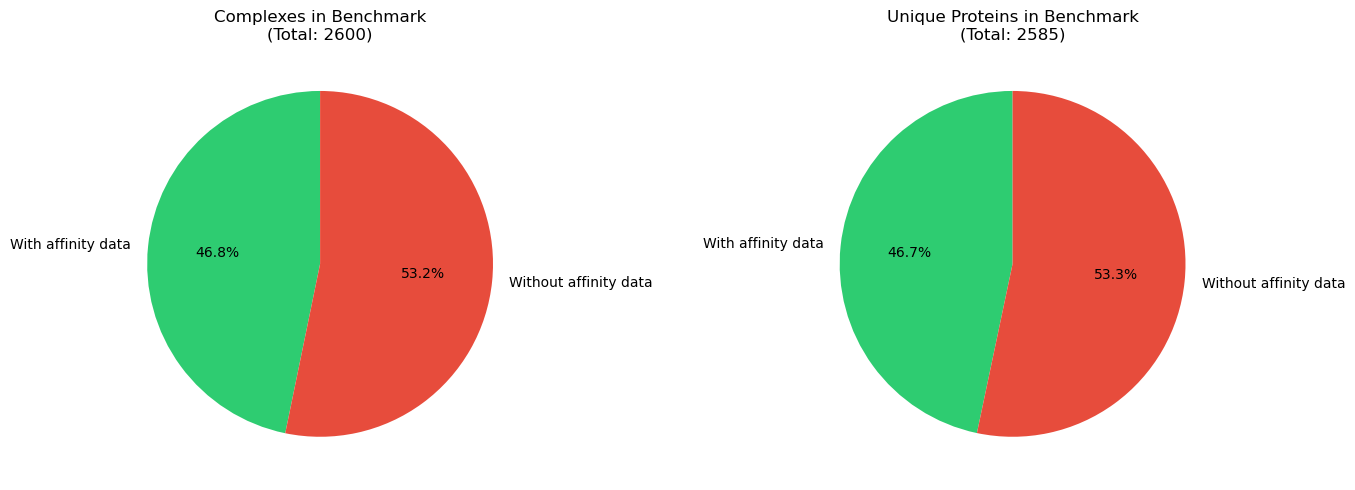

In [14]:
# Visualize the overlap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of complexes
complexes_data = [n_with_affinity, n_without_affinity]
complexes_labels = ['With affinity data', 'Without affinity data']
colors = ['#2ecc71', '#e74c3c']
ax1.pie(complexes_data, labels=complexes_labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title(f'Complexes in Benchmark\n(Total: {len(benchmark_df)})')

# Pie chart of unique proteins
proteins_data = [unique_proteins_with_affinity, len(proteins_without_data)]
proteins_labels = ['With affinity data', 'Without affinity data']
ax2.pie(proteins_data, labels=proteins_labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title(f'Unique Proteins in Benchmark\n(Total: {benchmark_df["pdb_id"].nunique()})')

plt.tight_layout()
plt.show()

## Process All Proteins in Affinity Directory

Now let's apply the filtering to ALL proteins and collect comprehensive statistics.

In [9]:
# Get all protein directories
affinity_path = Path('data/affinity')
all_proteins = sorted([d.name for d in affinity_path.iterdir() if d.is_dir()])

print(f"Found {len(all_proteins)} protein directories")
print(f"First 10: {all_proteins[:10]}")
print(f"Last 10: {all_proteins[-10:]}")

Found 4835 protein directories
First 10: ['5sc8', '5sc9', '5sca', '5scb', '5scc', '5scd', '5sce', '5scf', '5scg', '5sch']
Last 10: ['9f4h', '9f4j', '9f4n', '9f4p', '9f4u', '9f4w', '9f4x', '9f54', '9f5k', '9f7f']


In [10]:
# Process all proteins with progress tracking
from tqdm.auto import tqdm

all_results = {}
all_filtering_stats = {}
processing_errors = []

print("Processing all proteins...")
for protein_id in tqdm(all_proteins, desc="Filtering proteins"):
    try:
        csv_path = affinity_path / protein_id / f"{protein_id}_chembl_activities.csv"
        
        if not csv_path.exists():
            processing_errors.append((protein_id, "CSV file not found"))
            continue
        
        # Read and filter - now including IC50, Ki, and Kd
        df = pd.read_csv(csv_path)
        filtered_df, stats = filter_chembl_data(df, standard_types=['IC50', 'Ki', 'Kd'], verbose=False)
        
        # Store results
        all_results[protein_id] = filtered_df
        all_filtering_stats[protein_id] = stats
        
    except Exception as e:
        processing_errors.append((protein_id, str(e)))

print(f"\n✓ Successfully processed: {len(all_results)} proteins")
print(f"✗ Errors: {len(processing_errors)} proteins")

if processing_errors:
    print(f"\nFirst 5 errors:")
    for protein_id, error in processing_errors[:5]:
        print(f"  {protein_id}: {error}")

Processing all proteins...


Filtering proteins:   0%|          | 0/4835 [00:00<?, ?it/s]

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_69419/3541273573.py:18: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_69419/3541273573.py:18: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_69419/3541273573.py:18: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_69419/3541273573.py:18: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_69419/3541273573.py:18: DtypeWarning: Columns (6) have mixed types. Specify dtype option on i


✓ Successfully processed: 4835 proteins
✗ Errors: 0 proteins


## Aggregate Filtering Statistics Across All Proteins

In [11]:
# Create comprehensive statistics DataFrame
stats_rows = []
for protein_id, stats in all_filtering_stats.items():
    filtered_df = all_results[protein_id]
    
    row = {
        'protein': protein_id,
        'initial': stats['initial'],
        'after_standard_type': stats['after_standard_type'],
        'after_standard_units': stats['after_standard_units'],
        'after_pchembl_exists': stats['after_pchembl_exists'],
        'after_data_validity': stats.get('after_data_validity', stats['after_pchembl_exists']),
        'after_confidence': stats['after_confidence'],
        'after_deduplication': stats['after_deduplication'],
        'final_molecules': filtered_df['molecule_chembl_id'].nunique() if len(filtered_df) > 0 else 0,
        'final_assays': filtered_df['assay_chembl_id'].nunique() if len(filtered_df) > 0 else 0,
        'retention_rate': (stats['after_deduplication'] / stats['initial'] * 100) if stats['initial'] > 0 else 0
    }
    stats_rows.append(row)

all_stats_df = pd.DataFrame(stats_rows)

print("="*80)
print("OVERALL FILTERING STATISTICS")
print("="*80)
print(f"Total proteins processed: {len(all_stats_df)}")
print(f"Total initial records: {all_stats_df['initial'].sum():,}")
print(f"Total final records: {all_stats_df['after_deduplication'].sum():,}")
print(f"Overall retention rate: {all_stats_df['after_deduplication'].sum() / all_stats_df['initial'].sum() * 100:.2f}%")
print(f"\nAverage records per protein (initial): {all_stats_df['initial'].mean():.1f}")
print(f"Average records per protein (final): {all_stats_df['after_deduplication'].mean():.1f}")
print(f"Average retention rate: {all_stats_df['retention_rate'].mean():.2f}%")
print("="*80)

OVERALL FILTERING STATISTICS
Total proteins processed: 4835
Total initial records: 100,510,772
Total final records: 7,490,371
Overall retention rate: 7.45%

Average records per protein (initial): 20788.2
Average records per protein (final): 1549.2
Average retention rate: 25.99%


In [12]:
# Calculate total records removed at each filtering step
filter_steps = ['initial', 'after_standard_type', 'after_standard_units', 
                'after_pchembl_exists', 'after_data_validity', 
                'after_confidence', 'after_deduplication']

step_totals = {step: all_stats_df[step].sum() for step in filter_steps}
step_removed = {}

for i in range(len(filter_steps) - 1):
    current_step = filter_steps[i]
    next_step = filter_steps[i + 1]
    removed = step_totals[current_step] - step_totals[next_step]
    step_removed[f"{current_step}_to_{next_step}"] = removed

print("\nRecords removed at each filtering step:")
print("="*80)
print(f"{'Filtering Step':<50} {'Removed':<15} {'% of Initial':<15}")
print("="*80)

step_names = [
    'Standard Type (IC50/Ki/Kd)',
    'Standard Units (nM)',
    'pChEMBL Value Exists',
    'Data Validity',
    'Confidence Score (9)',
    'Deduplication'
]

for i, (key, removed) in enumerate(step_removed.items()):
    pct = removed / step_totals['initial'] * 100
    print(f"{step_names[i]:<50} {removed:<15,} {pct:<15.2f}%")

print("="*80)
print(f"{'Total Removed':<50} {step_totals['initial'] - step_totals['after_deduplication']:<15,} {(1 - step_totals['after_deduplication']/step_totals['initial'])*100:<15.2f}%")
print("="*80)


Records removed at each filtering step:
Filtering Step                                     Removed         % of Initial   
Standard Type (IC50/Ki/Kd)                         0               0.00           %
Standard Units (nM)                                2,071,746       2.06           %
pChEMBL Value Exists                               12,478,965      12.42          %
Data Validity                                      12,891,490      12.83          %
Confidence Score (9)                               6,063,663       6.03           %
Deduplication                                      59,514,537      59.21          %
Total Removed                                      93,020,401      92.55          %


## Visualization 1: Waterfall Chart of Filtering Steps

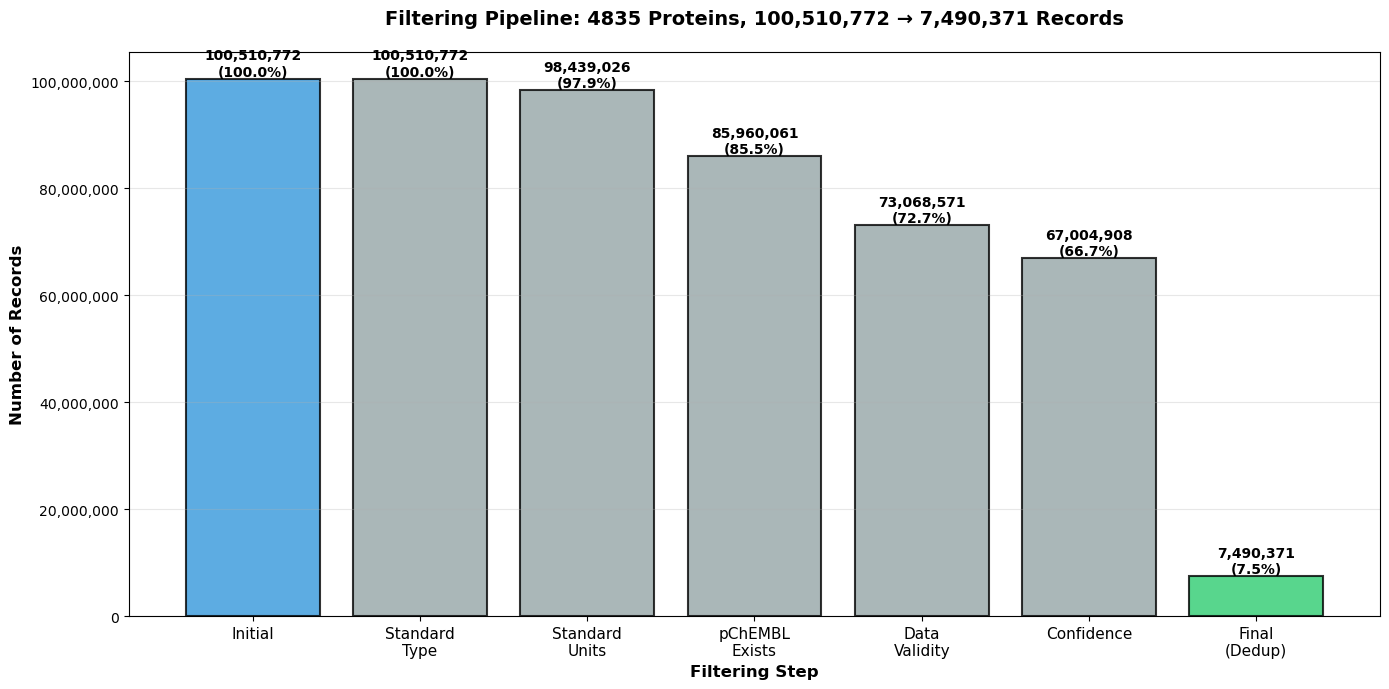

In [13]:
# Create waterfall chart showing cumulative filtering
fig, ax = plt.subplots(figsize=(14, 7))

totals = [step_totals[step] for step in filter_steps]
step_labels = ['Initial', 'Standard\nType', 'Standard\nUnits', 'pChEMBL\nExists', 
               'Data\nValidity', 'Confidence', 'Final\n(Dedup)']

# Plot bars
bars = ax.bar(range(len(totals)), totals, color=['#3498db' if i == 0 else '#2ecc71' if i == len(totals)-1 else '#95a5a6' for i in range(len(totals))], 
              edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, totals)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}\n({val/totals[0]*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(range(len(totals)))
ax.set_xticklabels(step_labels, fontsize=11)
ax.set_ylabel('Number of Records', fontsize=12, fontweight='bold')
ax.set_xlabel('Filtering Step', fontsize=12, fontweight='bold')
ax.set_title(f'Filtering Pipeline: {len(all_stats_df)} Proteins, {totals[0]:,} → {totals[-1]:,} Records', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

## Visualization 2: Distribution of Retention Rates Across Proteins

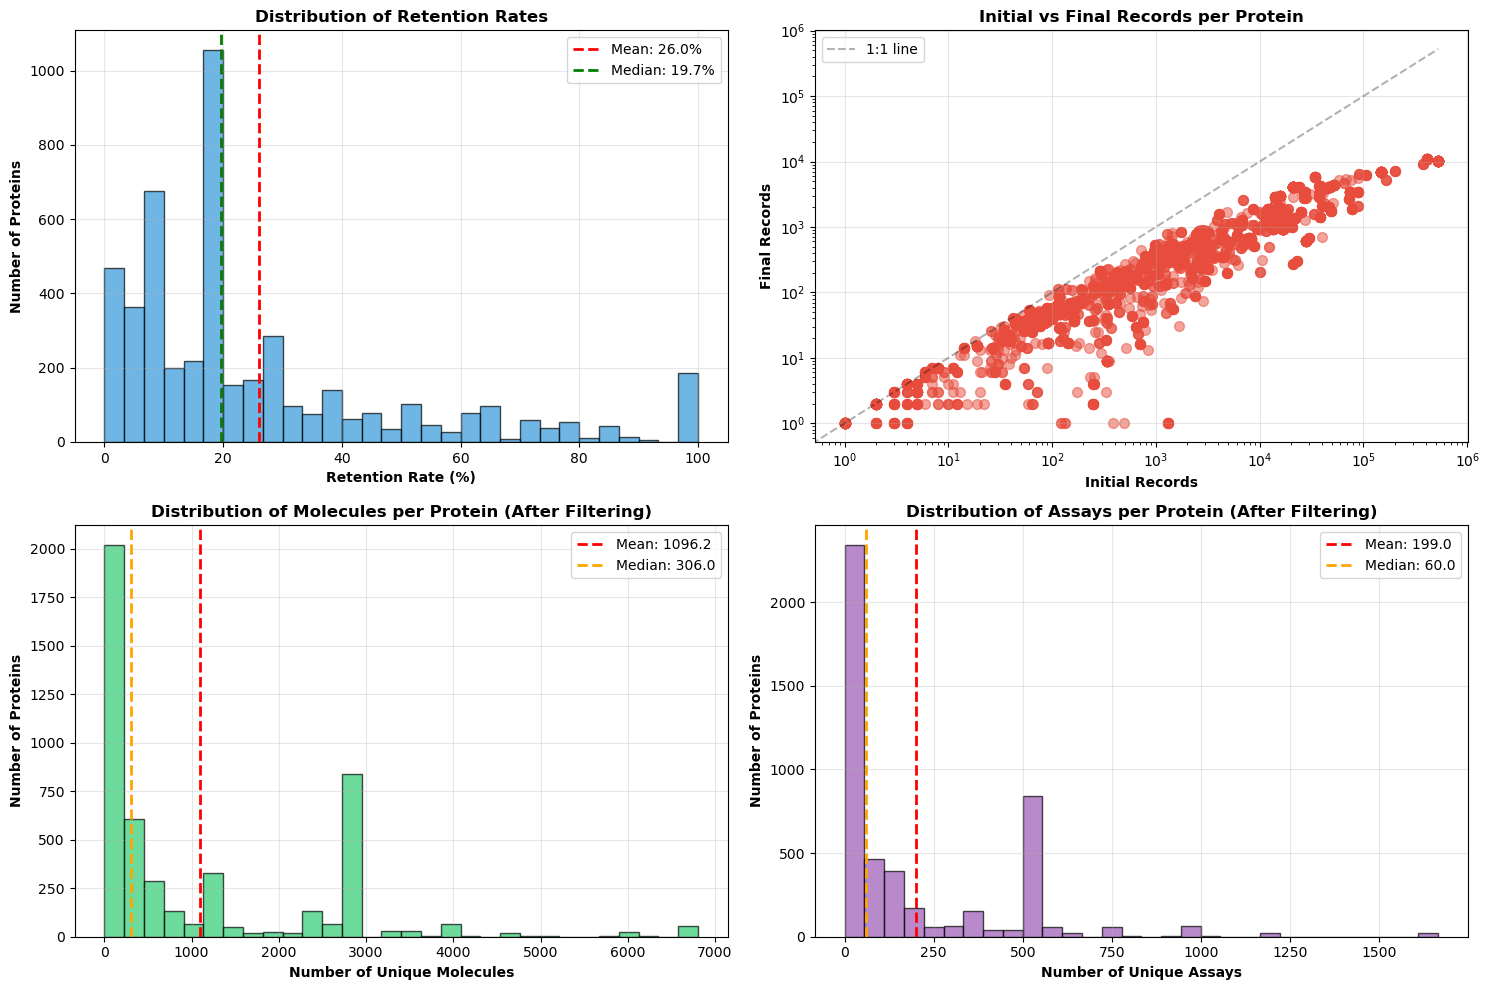

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Retention rate distribution
ax1 = axes[0, 0]
ax1.hist(all_stats_df['retention_rate'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
ax1.axvline(all_stats_df['retention_rate'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_stats_df["retention_rate"].mean():.1f}%')
ax1.axvline(all_stats_df['retention_rate'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {all_stats_df["retention_rate"].median():.1f}%')
ax1.set_xlabel('Retention Rate (%)', fontweight='bold')
ax1.set_ylabel('Number of Proteins', fontweight='bold')
ax1.set_title('Distribution of Retention Rates', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Initial vs Final records (log scale)
ax2 = axes[0, 1]
ax2.scatter(all_stats_df['initial'], all_stats_df['after_deduplication'], alpha=0.5, s=50, color='#e74c3c')
ax2.plot([0, all_stats_df['initial'].max()], [0, all_stats_df['initial'].max()], 'k--', alpha=0.3, label='1:1 line')
ax2.set_xlabel('Initial Records', fontweight='bold')
ax2.set_ylabel('Final Records', fontweight='bold')
ax2.set_title('Initial vs Final Records per Protein', fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Distribution of final molecules per protein
ax3 = axes[1, 0]
ax3.hist(all_stats_df['final_molecules'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
ax3.axvline(all_stats_df['final_molecules'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_stats_df["final_molecules"].mean():.1f}')
ax3.axvline(all_stats_df['final_molecules'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {all_stats_df["final_molecules"].median():.1f}')
ax3.set_xlabel('Number of Unique Molecules', fontweight='bold')
ax3.set_ylabel('Number of Proteins', fontweight='bold')
ax3.set_title('Distribution of Molecules per Protein (After Filtering)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Distribution of final assays per protein
ax4 = axes[1, 1]
ax4.hist(all_stats_df['final_assays'], bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
ax4.axvline(all_stats_df['final_assays'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_stats_df["final_assays"].mean():.1f}')
ax4.axvline(all_stats_df['final_assays'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {all_stats_df["final_assays"].median():.1f}')
ax4.set_xlabel('Number of Unique Assays', fontweight='bold')
ax4.set_ylabel('Number of Proteins', fontweight='bold')
ax4.set_title('Distribution of Assays per Protein (After Filtering)', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualization 3: Top/Bottom Proteins by Data Volume

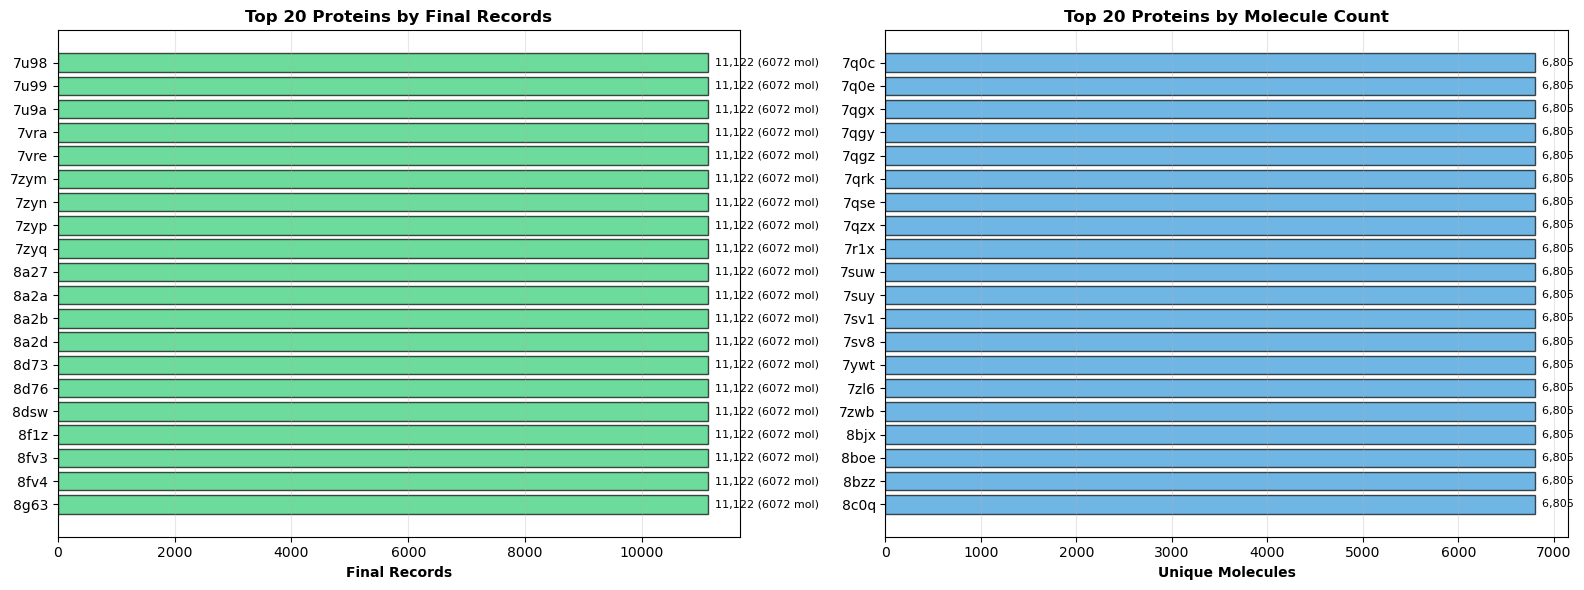

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 proteins by final records
top_20 = all_stats_df.nlargest(20, 'after_deduplication')
ax1 = axes[0]
bars1 = ax1.barh(range(len(top_20)), top_20['after_deduplication'], color='#2ecc71', alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['protein'])
ax1.set_xlabel('Final Records', fontweight='bold')
ax1.set_title('Top 20 Proteins by Final Records', fontweight='bold', fontsize=12)
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_20.iterrows()):
    ax1.text(row['after_deduplication'], i, f"  {row['after_deduplication']:,} ({row['final_molecules']} mol)", 
             va='center', fontsize=8)

# Top 20 proteins by molecule count
top_20_mol = all_stats_df.nlargest(20, 'final_molecules')
ax2 = axes[1]
bars2 = ax2.barh(range(len(top_20_mol)), top_20_mol['final_molecules'], color='#3498db', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(top_20_mol)))
ax2.set_yticklabels(top_20_mol['protein'])
ax2.set_xlabel('Unique Molecules', fontweight='bold')
ax2.set_title('Top 20 Proteins by Molecule Count', fontweight='bold', fontsize=12)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_20_mol.iterrows()):
    ax2.text(row['final_molecules'], i, f"  {row['final_molecules']:,}", 
             va='center', fontsize=8)

plt.tight_layout()
plt.show()

## Summary Statistics Table

In [16]:
# Generate summary statistics
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Proteins',
        'Total Initial Records',
        'Total Final Records',
        'Overall Retention Rate',
        '',
        'Avg Initial Records/Protein',
        'Median Initial Records/Protein',
        'Avg Final Records/Protein',
        'Median Final Records/Protein',
        '',
        'Avg Molecules/Protein',
        'Median Molecules/Protein',
        'Max Molecules (single protein)',
        '',
        'Avg Assays/Protein',
        'Median Assays/Protein',
        'Max Assays (single protein)',
        '',
        'Avg Retention Rate',
        'Median Retention Rate',
        'Min Retention Rate',
        'Max Retention Rate'
    ],
    'Value': [
        f"{len(all_stats_df):,}",
        f"{all_stats_df['initial'].sum():,}",
        f"{all_stats_df['after_deduplication'].sum():,}",
        f"{all_stats_df['after_deduplication'].sum() / all_stats_df['initial'].sum() * 100:.2f}%",
        '',
        f"{all_stats_df['initial'].mean():.1f}",
        f"{all_stats_df['initial'].median():.1f}",
        f"{all_stats_df['after_deduplication'].mean():.1f}",
        f"{all_stats_df['after_deduplication'].median():.1f}",
        '',
        f"{all_stats_df['final_molecules'].mean():.1f}",
        f"{all_stats_df['final_molecules'].median():.1f}",
        f"{all_stats_df['final_molecules'].max():,}",
        '',
        f"{all_stats_df['final_assays'].mean():.1f}",
        f"{all_stats_df['final_assays'].median():.1f}",
        f"{all_stats_df['final_assays'].max():,}",
        '',
        f"{all_stats_df['retention_rate'].mean():.2f}%",
        f"{all_stats_df['retention_rate'].median():.2f}%",
        f"{all_stats_df['retention_rate'].min():.2f}%",
        f"{all_stats_df['retention_rate'].max():.2f}%"
    ]
})

print("\n" + "="*80)
print("COMPREHENSIVE FILTERING SUMMARY")
print("="*80)
print(summary_stats.to_string(index=False))
print("="*80)


COMPREHENSIVE FILTERING SUMMARY
                        Metric       Value
                Total Proteins       4,835
         Total Initial Records 100,510,772
           Total Final Records   7,490,371
        Overall Retention Rate       7.45%
                                          
   Avg Initial Records/Protein     20788.2
Median Initial Records/Protein      2182.0
     Avg Final Records/Protein      1549.2
  Median Final Records/Protein       435.0
                                          
         Avg Molecules/Protein      1096.2
      Median Molecules/Protein       306.0
Max Molecules (single protein)       6,805
                                          
            Avg Assays/Protein       199.0
         Median Assays/Protein        60.0
   Max Assays (single protein)       1,665
                                          
            Avg Retention Rate      25.99%
         Median Retention Rate      19.70%
            Min Retention Rate       0.00%
            Max Reten

## Save Filtered Data and Statistics

In [17]:
# Save filtered data for each protein
output_base = Path('data/affinity_pruned')
output_base.mkdir(parents=True, exist_ok=True)

print(f"Saving filtered data to {output_base}...")
saved_count = 0

for protein_id, filtered_df in tqdm(all_results.items(), desc="Saving filtered CSVs"):
    if len(filtered_df) > 0:  # Only save if there's data
        protein_dir = output_base / protein_id
        protein_dir.mkdir(exist_ok=True)
        
        output_path = protein_dir / f"{protein_id}_chembl_activities_filtered.csv"
        filtered_df.to_csv(output_path, index=False)
        saved_count += 1

print(f"✓ Saved {saved_count} filtered CSV files")

# Save statistics summary
stats_output = output_base / 'filtering_statistics.csv'
all_stats_df.to_csv(stats_output, index=False)
print(f"✓ Saved statistics summary to {stats_output}")

# Save overall summary
summary_output = output_base / 'filtering_summary.txt'
with open(summary_output, 'w') as f:
    f.write("="*80 + "\n")
    f.write("FILTERING SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"Total proteins processed: {len(all_stats_df):,}\n")
    f.write(f"Total initial records: {all_stats_df['initial'].sum():,}\n")
    f.write(f"Total final records: {all_stats_df['after_deduplication'].sum():,}\n")
    f.write(f"Overall retention rate: {all_stats_df['after_deduplication'].sum() / all_stats_df['initial'].sum() * 100:.2f}%\n\n")
    
    f.write("Records removed at each step:\n")
    f.write("-"*80 + "\n")
    for i, (key, removed) in enumerate(step_removed.items()):
        pct = removed / step_totals['initial'] * 100
        f.write(f"{step_names[i]:<50} {removed:<15,} {pct:.2f}%\n")
    
    f.write("\n" + summary_stats.to_string(index=False) + "\n")
    f.write("="*80 + "\n")

print(f"✓ Saved overall summary to {summary_output}")

Saving filtered data to data/affinity_pruned...


Saving filtered CSVs:   0%|          | 0/4835 [00:00<?, ?it/s]

✓ Saved 4607 filtered CSV files
✓ Saved statistics summary to data/affinity_pruned/filtering_statistics.csv
✓ Saved overall summary to data/affinity_pruned/filtering_summary.txt


## Identify Proteins with Low/No Data After Filtering

In [18]:
# Proteins with no data after filtering
no_data = all_stats_df[all_stats_df['after_deduplication'] == 0]
print(f"Proteins with NO data after filtering: {len(no_data)}")
if len(no_data) > 0:
    print("\nProteins with zero records after filtering:")
    print(no_data[['protein', 'initial', 'retention_rate']].to_string(index=False))

# Proteins with very little data (< 10 records)
low_data = all_stats_df[(all_stats_df['after_deduplication'] > 0) & (all_stats_df['after_deduplication'] < 10)]
print(f"\nProteins with < 10 records after filtering: {len(low_data)}")
if len(low_data) > 0:
    print(low_data[['protein', 'initial', 'after_deduplication', 'final_molecules', 'retention_rate']].sort_values('after_deduplication').to_string(index=False))

# Proteins with good data (>= 100 records)
good_data = all_stats_df[all_stats_df['after_deduplication'] >= 100]
print(f"\nProteins with >= 100 records after filtering: {len(good_data)} ({len(good_data)/len(all_stats_df)*100:.1f}%)")
print(f"These proteins contain {good_data['after_deduplication'].sum():,} records ({good_data['after_deduplication'].sum()/all_stats_df['after_deduplication'].sum()*100:.1f}% of total)")

Proteins with NO data after filtering: 228

Proteins with zero records after filtering:
protein  initial  retention_rate
   5smj       19             0.0
   7h6l      171             0.0
   7h6q      171             0.0
   7h6w      171             0.0
   7h6z      171             0.0
   7h71      171             0.0
   7h73      171             0.0
   7h76      171             0.0
   7h78      171             0.0
   7h7a      171             0.0
   7h7i      171             0.0
   7h7k      171             0.0
   7h7n      171             0.0
   7h7r      171             0.0
   7h7x      171             0.0
   7h8h      171             0.0
   7q44        1             0.0
   7qb7      400             0.0
   7qc2      400             0.0
   7qei        1             0.0
   7qem       69             0.0
   7qh1      344             0.0
   7qpi      241             0.0
   7sit        1             0.0
   7siz        1             0.0
   7slr      385             0.0
   7sls      385     